In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

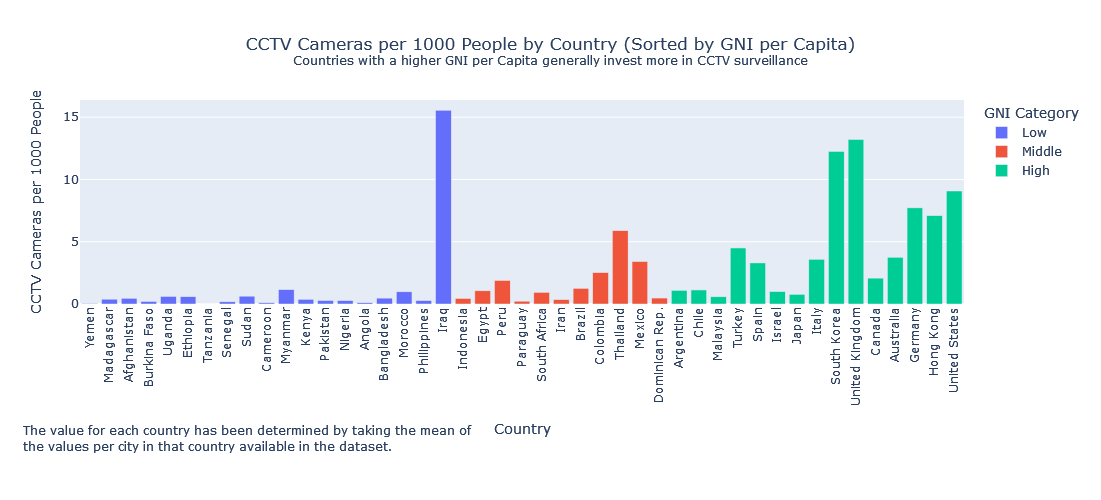

In [50]:
# Load the data (replace with the actual file paths)
df_cctv = pd.read_csv('datasets/cctv.csv')
df_hdi = pd.read_csv('datasets/Human Development Index.csv')

# Select relevant columns and rename for clarity
df_hdi = df_hdi[['Country', 'Gross National Income Per Capita (2021)']]
df_cctv = df_cctv[['Country', '# of CCTV Cameras', '# of People (2023)']]
# Clean the data: handle missing values
df_hdi.dropna(subset=['Gross National Income Per Capita (2021)'], inplace=True)
df_cctv.dropna(subset=['# of CCTV Cameras', '# of People (2023)'], inplace=True)

# Convert '# of CCTV Cameras' and '# of People (2023)' columns to integers (remove commas)
df_cctv['# of CCTV Cameras'] = df_cctv['# of CCTV Cameras'].str.replace(',', '').astype(int)
df_cctv['# of People (2023)'] = df_cctv['# of People (2023)'].str.replace(',', '').astype(int)

# Calculate the number of CCTV cameras per 1000 people
df_cctv['CCTV Cameras per 1000 People'] = df_cctv['# of CCTV Cameras'] / df_cctv['# of People (2023)'] * 1000

# Group by country and calculate the total number of cameras and the number of CCTV cameras per 1000 people
total_cameras_per_land = df_cctv.groupby('Country', as_index=False).agg({
    '# of CCTV Cameras': 'mean',
    'CCTV Cameras per 1000 People': 'mean'
})

# Merge the DataFrames on 'Country'
merged_df = pd.merge(total_cameras_per_land, df_hdi, on='Country')

merged_df.replace("Dominican Republic", "Dominican Rep.", inplace = True)


# Exclude specific countries because of outliers or no information
excluded_countries = ['China', 'India', 'Saudi Arabia']
merged_df = merged_df[~merged_df['Country'].isin(excluded_countries)]

# Categorize GNI per Capita into low, middle, high
gni_bins = [0, 10000, 20000, float('inf')]
gni_labels = ['Low', 'Middle', 'High']
merged_df['GNI Category'] = pd.cut(merged_df['Gross National Income Per Capita (2021)'], bins=gni_bins, labels=gni_labels)

# Sort the merged data by GNI per Capita
merged_df_sorted = merged_df.sort_values(by='Gross National Income Per Capita (2021)')

# Create the interactive bar chart
fig = px.bar(
    merged_df_sorted,
    x='Country',
    y='CCTV Cameras per 1000 People',
    color='GNI Category',
    hover_data=['# of CCTV Cameras', 'Gross National Income Per Capita (2021)'],
    labels={'CCTV Cameras per 1000 People': 'CCTV Cameras per 1000 People', 'Gross National Income Per Capita (2021)': 'GNI per Capita'},
    title='CCTV Cameras per 1000 People by Country (Sorted by GNI per Capita)<br><sup>Countries with a higher GNI per Capita generally invest more in CCTV surveillance</sup>'
)

# Update the layout to improve readability
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='CCTV Cameras per 1000 People',
    xaxis_tickangle=-90,
    yaxis=dict(tickmode='linear', tick0=0, dtick=5),
    hovermode='closest',
    height = 500,
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin={'b': 196, 't': 100}
)

fig.add_annotation(x=-0.07, y=-0.75,
                   xref="paper", yref="paper",
                   align='left',
                   xanchor='left', yanchor='bottom',
                   showarrow=False,
                   text='The value for each country has been determined by taking the mean of<br>' 
                   + 'the values per city in that country available in the dataset.'
                  )

# Show the plot
fig.show()